<h1>Выпускной проект<a class="tocSkip"></h1>
<h3>Описание проекта<a class="tocSkip"></h3>

Помогите «Нупозвони» найти самых неэффективных операторов. Признаки низкой эффективности:

- много пропущенных входящих вызовов;
- долгое ожидания ответа при входящих внешних вызовах;
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков

<h4>Описание данных<a class="tocSkip"></h4>

Датасет описывает использование услуг «Нупозвони» — провайдера виртуальный телефонии. Его клиенты — колл-центры, которые: 

- распределяют входящие вызовы на операторов;
- совершают исходящие вызовы силами операторов

Также операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.

Колонки в `telecom_dataset.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math as mth
from scipy import stats as st

### Загрузка и предобработка данных

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
try:
    df = pd.read_csv('telecom_dataset.csv')
except:
    print('Ошибка подгрузки данных')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [5]:
df.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
28615,167185,2019-10-04 00:00:00+03:00,out,False,917682.00,False,2,15,37
48762,168187,2019-11-14 00:00:00+03:00,out,False,937860.00,False,52,4028,5121
40059,167799,2019-10-14 00:00:00+03:00,out,False,925104.00,True,6,0,212
30790,167359,2019-11-01 00:00:00+03:00,out,True,912722.00,True,6,0,105
12551,166727,2019-10-26 00:00:00+03:00,in,False,NaN,True,1,0,2


#### Столбец operator_id

In [6]:
df.operator_id.nunique()

1092

1092 - разных оператора, посмотрим на количество пропущенных значений

In [7]:
df.operator_id.isnull().sum()

8172

8172 пропуска - нет номеров оператора, эффективность которых нам надо оценить, это 15.16% это общих данных, посмотрим на пропуски подробнее

In [8]:
df.query('operator_id.isna()==True', engine='python').sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
12615,166732,2019-10-09 00:00:00+03:00,in,True,NaN,True,1,0,5
3434,166485,2019-11-08 00:00:00+03:00,in,False,NaN,True,1,0,6
41715,167888,2019-11-04 00:00:00+03:00,in,False,NaN,True,5,0,144
6668,166582,2019-08-23 00:00:00+03:00,in,False,NaN,True,23,0,261
2844,166482,2019-10-08 00:00:00+03:00,in,False,NaN,True,1,0,3
22131,167053,2019-09-10 00:00:00+03:00,in,False,NaN,True,2,0,58
26816,167158,2019-09-22 00:00:00+03:00,in,False,NaN,True,1,0,31
10782,166680,2019-10-12 00:00:00+03:00,in,False,NaN,True,3,0,22
1203,166405,2019-10-15 00:00:00+03:00,in,False,NaN,True,34,0,712
5338,166520,2019-09-21 00:00:00+03:00,in,False,NaN,True,4,0,33


Мы видим, что записи о входящих и пропущенных звонках, посмотрим соотношение подробнее

In [9]:
df.query('operator_id.isna()==True', engine='python').direction.value_counts()

in     7972
out     200
Name: direction, dtype: int64

In [10]:
df.query('operator_id.isna()==True', engine='python').is_missed_call.value_counts()

True     8050
False     122
Name: is_missed_call, dtype: int64

В NaN-ах 98.5% это записи о пропущеных звонках и 97.6% записи о входящих звонках;  
Можно предположить, что это звонки которые провисели в ожидании и им так и не был "назначен" оператор, потому что все были заняты. Если это предположение верно, то КЦ в пиковые нагрузки не хватает операторов;  
Несмотря на отсутствие номера оператора, эта часть данных будет полезна для оценки работы КЦ и для вычисления порогов эффективности операторов, поэтому данные удалять не будем, а для удобства работы с ними присвоим пропущенным значениям номер "333"

In [11]:
df.operator_id.fillna(333, inplace=True)

Оperator_id это идентификатор, изменим тип данных на целочисленный

In [12]:
df.operator_id = df.operator_id.astype('int64')

#### Столбец internal

Посмотрим на количество пропущенных значений и на сами данные

In [13]:
df.internal.isnull().sum()

117

In [14]:
df.query('internal.isna()==True', engine='python').sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,333,True,1,0,59
35728,167534,2019-10-16 00:00:00+03:00,in,NaN,929332,False,1,5,18
37964,167650,2019-10-01 00:00:00+03:00,in,NaN,921318,False,1,124,131
24500,167110,2019-10-11 00:00:00+03:00,in,NaN,333,True,2,0,8
29887,167264,2019-11-15 00:00:00+03:00,in,NaN,919552,False,1,125,158
43860,168018,2019-11-28 00:00:00+03:00,in,NaN,333,True,1,0,2
24493,167110,2019-09-20 00:00:00+03:00,in,NaN,333,True,1,0,4
44352,168041,2019-11-06 00:00:00+03:00,in,NaN,936514,False,1,1,24
35725,167534,2019-10-15 00:00:00+03:00,in,NaN,333,True,1,0,15
50718,168252,2019-11-22 00:00:00+03:00,in,NaN,940658,False,1,20,27


60 записей с пропущенными значениями, все звонки входящие и длительность разговора > 0, причина возникновения пропусков не понятна, возможно ошибка возникла при сборе или агрегации данных;  
Для оценки эффективности операторов, если звонок входящий, внутренний он или внешний не имеет значения, поэтому данные удалять не будем, а пропуски заменим на 'False'

In [15]:
df.loc[df.internal.isna(), 'internal'] = False

In [16]:
df.internal.value_counts()

False    47738
True      6164
Name: internal, dtype: int64

#### Столбец user_id

In [17]:
df.user_id.nunique()

307

In [18]:
df.user_id.value_counts()

168187    2580
166658    2107
167497    1405
167626    1311
166916    1308
          ... 
166584       1
167981       1
168578       1
168013       1
166554       1
Name: user_id, Length: 307, dtype: int64

Данные корректны, количество КЦ в нашем датасете - 290

#### Столбец date

Сделаем столбец date удобно читаемым и преобразуем тип к datetime64

In [19]:
df['date'] = pd.to_datetime(df.date).dt.date
df['date'] = pd.to_datetime(df.date)

In [20]:
df.sample(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
31617,167445,2019-10-29,in,False,920732,False,2,403,415


#### Столбцы direction и is_missed_call

In [21]:
df.direction.value_counts()

out    31917
in     21985
Name: direction, dtype: int64

In [22]:
df.is_missed_call.value_counts()

False    30334
True     23568
Name: is_missed_call, dtype: int64

Данные корректны, 69% - записи о исходящих звонках, 31% - о входящих; 66% - записи о принятых звонки, 34% - о пропущенных звонках

#### Столбцы calls_count call_duration total_call_duration

In [23]:
for col in ['calls_count', 'call_duration', 'total_call_duration']:
    display(df[col].describe().loc[['min','max','mean','50%']])

min       1.00
max    4817.00
mean     16.45
50%       4.00
Name: calls_count, dtype: float64

min         0.00
max    144395.00
mean      866.68
50%        38.00
Name: call_duration, dtype: float64

min         0.00
max    166155.00
mean     1157.13
50%       210.00
Name: total_call_duration, dtype: float64

Максимумы вызывают вопросы о реалистичности данных, посмотрим на эти строки

In [24]:
df.query('calls_count==4817')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
40733,167827,2019-11-11,out,False,929428,True,4817,0,5529


In [25]:
df.query('call_duration==144395')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6946,166582,2019-09-25,out,False,885876,False,1230,144395,166155


4817 сброшенных звонков со средней длительностью чуть более секунды, с функцией автодозвона такое вполне возможно;
1230 разговоров общей длительностью более 46-ти часов за сутки, очевидно - тут какая то ошибка в сборе или агрегации данных;  
Поскольку в анализе мы оперируем только средними значеними длительности разговоров, а здесь средняя продолжительность (135 секунд) аномальной не выглядит;  
Посмотрим на звонки операторов 929428 и 885876 подробнее

In [26]:
df.query('operator_id==929428').sort_values(by='calls_count', ascending=False)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
40733,167827,2019-11-11,out,False,929428,True,4817,0,5529
40671,167827,2019-10-31,out,False,929428,True,2614,0,45312
40690,167827,2019-11-05,out,False,929428,True,1533,0,27889
40680,167827,2019-11-01,out,False,929428,True,1529,0,28017
40708,167827,2019-11-07,out,False,929428,True,1365,0,24450
...,...,...,...,...,...,...,...,...,...
40588,167827,2019-10-19,out,False,929428,False,62,4250,5514
40609,167827,2019-10-22,out,False,929428,True,25,0,798
40516,167827,2019-10-10,out,False,929428,False,8,337,419
40525,167827,2019-10-11,out,False,929428,True,5,0,86


In [27]:
df.query('operator_id==929428 & date=="2019-10-31"')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
40671,167827,2019-10-31,out,False,929428,True,2614,0,45312
40673,167827,2019-10-31,out,False,929428,False,116,2644,4447


In [28]:
df.query('operator_id==885876').sort_values(by='total_call_duration', ascending=False)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6946,166582,2019-09-25,out,False,885876,False,1230,144395,166155
6950,166582,2019-09-26,out,False,885876,False,843,132206,146903
6808,166582,2019-09-09,out,False,885876,False,1138,121093,141930
6889,166582,2019-09-18,out,False,885876,False,1013,121664,140050
6833,166582,2019-09-12,out,False,885876,False,696,125286,138643
...,...,...,...,...,...,...,...,...,...
6772,166582,2019-09-05,in,False,885876,True,1,0,5
6823,166582,2019-09-11,in,False,885876,True,1,1,4
6937,166582,2019-09-24,in,False,885876,True,1,0,4
6713,166582,2019-08-29,out,True,885876,True,2,0,2


In [29]:
df.query('operator_id==885876 & date=="2019-09-25"')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6941,166582,2019-09-25,out,False,885876,True,796,0,23081
6942,166582,2019-09-25,in,False,885876,False,13,611,753
6946,166582,2019-09-25,out,False,885876,False,1230,144395,166155


31 октября 2019-го оператор 929428 совершил 2730 звонков за 13.8-часов;  
Оператор 885876 регулярно проводит на телефоне за день больше времени, чем часов в сутках (ошибка сбора данных), при этом средние значения времени вполне нормальны - оставим данные как есть

#### Проверка is_missed_call + call_duration

Посмотрим есть ли пропущенные звонки с продолжительностью разговора больше нуля

In [30]:
df.query('is_missed_call==True & call_duration>0').sort_values(by='call_duration', ascending=False)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
50809,168252,2019-11-25,in,False,940630,True,2,741,747
50140,168252,2019-10-28,in,False,940658,True,3,670,681
50433,168252,2019-11-12,in,False,940588,True,3,638,651
50144,168252,2019-10-28,in,False,940630,True,4,636,652
50507,168252,2019-11-14,in,False,940588,True,4,601,624
...,...,...,...,...,...,...,...,...,...
22878,167071,2019-11-06,in,False,913942,True,2,1,46
22887,167071,2019-11-07,in,False,913942,True,1,1,17
22908,167071,2019-11-12,in,False,913942,True,4,1,22
41886,167888,2019-11-27,in,False,928886,True,1,1,17


Очередная ошибка-брак в данных, исправим флаг is_missed_call на корректный

In [31]:
df.loc[(df.is_missed_call==True) & (df.call_duration>0), 'is_missed_call'] = False

#### Проверка и удаление дубликатов

In [32]:
df.duplicated().sum()

4900

In [33]:
df[df.duplicated(keep=False)].sort_values(by=['date','operator_id'])

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1772,166406,2019-08-03,in,False,333,True,1,0,14
1777,166406,2019-08-03,in,False,333,True,1,0,14
6,166377,2019-08-05,out,False,880020,True,8,0,50
8,166377,2019-08-05,out,False,880020,True,8,0,50
1796,166406,2019-08-06,out,False,879896,False,35,4119,4489
...,...,...,...,...,...,...,...,...,...
41326,167829,2019-11-28,in,False,969272,False,33,1896,2040
49880,168225,2019-11-28,out,False,970252,False,2,141,188
49894,168225,2019-11-28,out,False,970252,False,2,141,188
17594,166940,2019-11-28,out,False,972460,False,18,1089,1266


4900 "двойных дубля", почти 10% от данных, причина возникновения визуально неопределима, удалим их

In [34]:
df.drop_duplicates(inplace = True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  object        
 4   operator_id          49002 non-null  int64         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(5), object(2)
memory usage: 3.4+ MB


#### Вывод

 * Загрузили и проверили данные;
 * В столбце operator_id заменили 8172 пустых значений на выдуманный id = 333;
 * В столбце internal заменили пропущенные значения на False;
 * В столбце is_missed_call флаг не сочетающийся по логике со столбцом call_duration исправили на корректный;
 * Изменили тип данных у столбцов date и operator_id;
 * Нашли и удалили 4900 дублей

### Исследовательский анализ данных, категоризация

#### Данные и период, анализ количества звонков

In [36]:
df.date.describe()

count                   49002
unique                    119
top       2019-11-25 00:00:00
freq                     1109
first     2019-08-02 00:00:00
last      2019-11-28 00:00:00
Name: date, dtype: object

У нас данные за 119 дней, со 2-го августа 2019 по 28 ноября 2019 года;  
Посмотрим как распределены звонки за указанный период

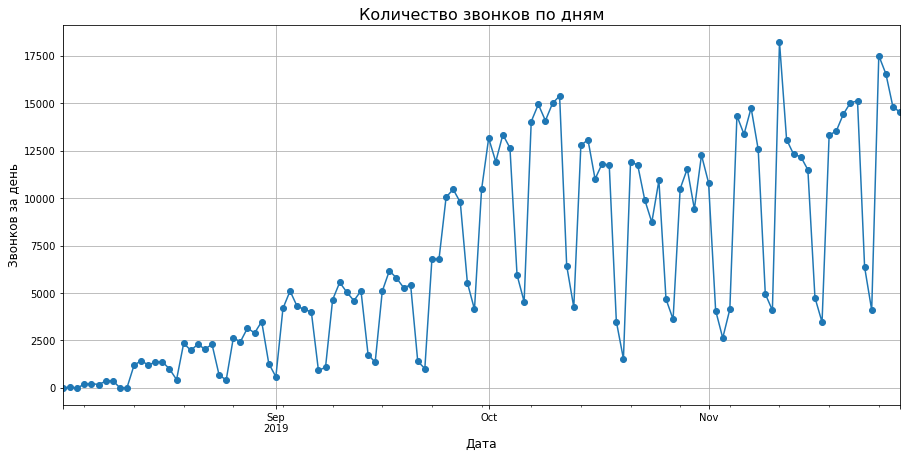

In [37]:
(df
 .pivot_table(index='date', values='calls_count', aggfunc='sum')
 .plot(figsize=(15,7), style ='-o', grid=True, legend=False)
)
plt.title('Количество звонков по дням', fontsize=16)
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Звонков за день', fontsize = 12);

Число звонков в день растет со 2-го августа по 1-е октября после чего стабилизируется и остается примерно на одном уровне до конца исследуемого периода; можно предположить что с августа по октябрь данные мы получили неполные;  
На графике видно регулярное 2-х дневное резкое падение числа звонков, скорее всего это выходные дни, проверим это предположение

Посмотрим на распределение звонков по дням недели, создадим столбец с днем недели

In [38]:
df['weekday'] = df.date.dt.day_name()

In [39]:
df.sample(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,weekday
20133,166997,2019-10-08,out,False,903318,True,2,0,8,Tuesday


In [40]:
df_week = (df.groupby('weekday').agg({'calls_count':'sum'})
                                .sort_values(by=['calls_count'], ascending=False)
                                .reset_index()
          ) 
df_week['ratio'] = df_week['calls_count'] / df['calls_count'].sum()
df_week.style.format({'ratio': '{:.1%}'})

,weekday,calls_count,ratio
0,Tuesday,151663,18.8%
1,Thursday,148757,18.4%
2,Wednesday,143218,17.8%
3,Monday,139918,17.3%
4,Friday,132549,16.4%
5,Saturday,53349,6.6%
6,Sunday,37255,4.6%


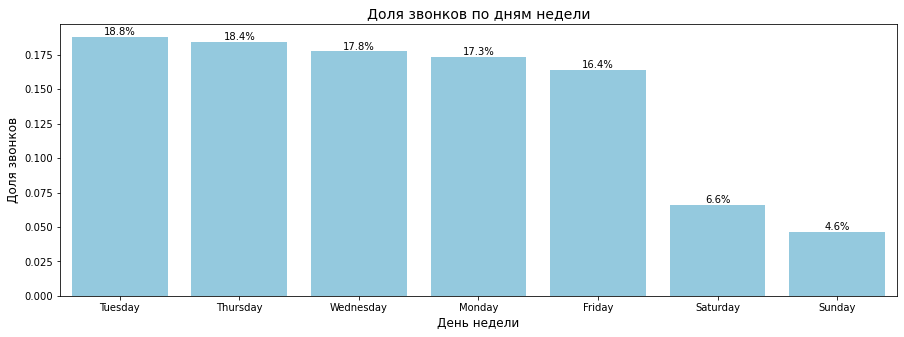

In [41]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='weekday', y='ratio', data=df_week, color='skyblue')
for i, val in enumerate(df_week.ratio.values):
    plt.text(i, val, '{:.1%}'.format(val), horizontalalignment='center', verticalalignment='bottom',fontsize=10)
plt.title("Доля звонков по дням недели", fontsize = 14)
plt.xlabel("День недели", fontsize = 12)
plt.ylabel("Доля звонков", fontsize = 12);

Больше всего звонков совершено во вторник 151663 (18.8%), меньше всего в выходные - воскресенье 37255 (4.6%);  
В рабочие дни совершено 88.8% всех звонков, звонки распределены между днями равномерно - разница между пятницей и вторником всего 2.4%, а разница между любым будним днем и субботой больше чем в 2.5-раза

Посмотрим на соотношение внутренних звонков к внешним 

In [42]:
'{0:.2%}'.format((df.query('internal==True').calls_count.sum())/(df.calls_count.sum()))

'1.82%'

Внутренних звонков меньше 2-х процентов от общего числа, поэтому при анализе операторов отдельно их выделять не будем

#### Исследовательский анализ операторов

In [43]:
df.operator_id.nunique()

1093

У нас 1093 идентификатора операторов, один из них 'искусственный' за номером 333;  
В датасете агрегированные данные по каждому дню, поэтому анализировать возможно либо средние, либо сумарные показатели;  
"Разберем обратно" данные на составные части и сгруппируем новую таблицу по operator_id

In [44]:
# создаем отдельные столбцы по принятым входящим с количеством звонков, длинной разговора и общей продолжительнотью звонков
df['c_in'] = df.loc[(df.is_missed_call==False) & (df.direction=="in"), 'calls_count']
df['c_in_cd'] = df.loc[(df.is_missed_call==False) & (df.direction=="in"), 'call_duration']
df['c_in_tcd'] = df.loc[(df.is_missed_call==False) & (df.direction=="in"), 'total_call_duration']

In [45]:
# столбцы по пропущенным входящих с количеством звонков и общей продолжительнотью звонка
df['cm_in'] = df.loc[(df.is_missed_call==True) & (df.direction=="in"), 'calls_count']
df['cm_in_tcd'] = df.loc[(df.is_missed_call==True) & (df.direction=="in"), 'total_call_duration']

In [46]:
# столбцы по состоявшимся исходящим с количеством звонков, длинной разговора и общей продолжительнотью звонка
df['c_out'] = df.loc[(df.is_missed_call==False) & (df.direction=="out"), 'calls_count']
df['c_out_cd'] = df.loc[(df.is_missed_call==False) & (df.direction=="out"), 'call_duration']
df['c_out_tcd'] = df.loc[(df.is_missed_call==False) & (df.direction=="out"), 'total_call_duration']

In [47]:
# столбцы по пропущенным исходящим с количеством звонков и общей продолжительнотью звонков
df['cm_out'] = df.loc[(df.is_missed_call==True) & (df.direction=="out"), 'calls_count']
df['cm_out_tcd'] = df.loc[(df.is_missed_call==True) & (df.direction=="out"), 'total_call_duration']

In [48]:
# столбец с числом пропущенных входящих у которых не назначен оператор (operator_id=333)
df['cm_333'] = df.loc[(df.is_missed_call==True) & (df.direction=="in") & (df.operator_id==333), 'calls_count']

In [49]:
# заполняем пропуски нулями
df.fillna(0, inplace=True)
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,weekday,...,c_in_cd,c_in_tcd,cm_in,cm_in_tcd,c_out,c_out_cd,c_out_tcd,cm_out,cm_out_tcd,cm_333
0,166377,2019-08-04,in,False,333,True,2,0,4,Sunday,...,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,2.00
1,166377,2019-08-05,out,True,880022,True,3,0,5,Monday,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,5.00,0.00
2,166377,2019-08-05,out,True,880020,True,1,0,1,Monday,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
3,166377,2019-08-05,out,True,880020,False,1,10,18,Monday,...,0.00,0.00,0.00,0.00,1.00,10.00,18.00,0.00,0.00,0.00
4,166377,2019-08-05,out,False,880022,True,3,0,25,Monday,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,25.00,0.00


In [50]:
# группируем данные, оператора с номером 333 - фильтруем
operator_df = (df.query('operator_id != 333')
                    .groupby('operator_id')
                    .agg({'date':'nunique', 'c_in':'sum','cm_in':'sum','c_out':'sum','cm_out':'sum','c_in_cd':'sum','c_in_tcd':'sum','cm_in_tcd':'sum','c_out_cd':'sum','c_out_tcd':'sum','cm_out_tcd':'sum'})
                    .reset_index()
                    .rename(columns={'date': 'work_days'})
)
operator_df.head(5)

,operator_id,work_days,c_in,cm_in,c_out,cm_out,c_in_cd,c_in_tcd,cm_in_tcd,c_out_cd,c_out_tcd,cm_out_tcd
0,879896,50,58.00,0.00,621.00,251.00,5616.00,6190.00,0.00,58246.00,64210.00,5737.00
1,879898,84,104.00,0.00,4849.00,2360.00,6353.00,8033.00,0.00,251038.00,303521.00,49734.00
2,880020,14,7.00,0.00,16.00,22.00,299.00,353.00,0.00,1946.00,2036.00,136.00
3,880022,42,8.00,0.00,84.00,105.00,512.00,624.00,0.00,14635.00,15191.00,3110.00
4,880026,77,24.00,0.00,1560.00,648.00,1587.00,1730.00,0.00,151739.00,161523.00,12273.00


In [51]:
# вычисляем различные параметры для будущей оценки эффективности операторов, подробное описание будет ниже
operator_df['calls_in_pd'] = (operator_df.c_in+operator_df.cm_in)/(operator_df.work_days)
operator_df['miss_in_pct'] = (operator_df.cm_in)/(operator_df.c_in+operator_df.cm_in)*100
operator_df['calls_made_pd'] = (operator_df.c_out)/(operator_df.work_days)
operator_df['calls_miss_pd'] = (operator_df.cm_out)/(operator_df.work_days)
operator_df['rc_wait_time'] = (operator_df.c_in_tcd-operator_df.c_in_cd)/(operator_df.c_in)
operator_df['avr_call_in'] = (operator_df.c_in_tcd+operator_df.cm_in_tcd)/(operator_df.c_in+operator_df.cm_in)
operator_df['mc_wait_time'] = (operator_df.cm_in_tcd)/(operator_df.cm_in)
operator_df['avr_call_out'] = (operator_df.c_out_tcd+operator_df.cm_out_tcd)/(operator_df.c_out+operator_df.cm_out)

In [52]:
# убираем ненужные столбцы
operator_df.drop(['c_in','cm_in','c_out','cm_out','c_in_cd','c_in_tcd','cm_in_tcd','c_out_cd','c_out_tcd','cm_out_tcd'], axis=1, inplace=True)

In [53]:
operator_df.sort_values(by='work_days', ascending=False).head(10)

,operator_id,work_days,calls_in_pd,miss_in_pct,calls_made_pd,calls_miss_pd,rc_wait_time,avr_call_in,mc_wait_time,avr_call_out
28,885876,97,10.23,1.41,362.13,240.31,9.04,68.79,12.57,96.94
108,893804,93,26.16,0.25,22.58,14.12,5.12,76.07,6.50,50.84
203,901880,88,20.74,0.60,18.56,8.28,5.23,145.70,8.09,91.83
204,901884,87,6.51,0.00,16.18,7.08,13.56,191.93,NaN,112.15
48,889410,87,5.05,0.00,8.76,2.91,6.33,84.87,NaN,58.22
162,899250,86,3.33,1.40,10.01,5.97,16.08,102.44,10.75,50.06
1,879898,84,1.24,0.00,57.73,28.10,16.15,77.24,NaN,49.00
224,903254,82,2.96,0.00,13.48,4.39,17.01,105.06,NaN,73.56
12,882686,80,9.57,0.52,24.21,11.84,14.71,202.66,15.75,95.65
29,885890,80,15.55,1.69,439.95,297.26,9.07,72.98,9.95,79.57


- `operator_id` — идентификатор оператора
- `work_days` — число рабочих дней оператора
- `calls_in_pd` — среднее число входящих звонков у оператора за день
- `miss_in_pct` — процент пропущенных входящих звонков
- `calls_made_pd` — среднее число "дозвонов" оператора за день
- `calls_miss_pd` — среднее число "недозвонов" оператора за день
- `rc_wait_time` — среднее время ожидания (в секундах) у принятых звонков
- `avr_call_in` — общее среднее время (в секундах) входящих звонков 
- `mc_wait_time` — среднее время ожидания (в секундах) у пропущенных звонков
- `avr_call_out` — общее среднее время (в секундах) потраченое оператором на исходящий звонк

In [54]:
operator_df.describe().loc[['mean','50%','75%','min','max']]

,operator_id,work_days,calls_in_pd,miss_in_pct,calls_made_pd,calls_miss_pd,rc_wait_time,avr_call_in,mc_wait_time,avr_call_out
mean,925517.54,17.99,2.96,0.91,12.29,10.79,17.46,119.65,20.09,76.74
50%,925105.00,12.00,1.00,0.00,2.00,1.44,14.35,101.33,15.00,61.69
75%,944211.50,26.25,2.00,0.00,10.57,6.85,21.56,146.42,25.67,91.34
min,879896.00,1.00,0.00,0.00,0.00,0.00,0.68,7.00,1.00,0.00
max,973286.00,97.00,136.23,33.33,439.95,579.33,115.50,1808.00,111.00,1338.00


Максимальное число рабочих дней оператора - 97, медиана всего 12-ть дней;  
Средний процент пропущенных звонков 0.91%, медиана вообще нулевая;  
Медианное время ожидания при пропущенном звонке отличается от среднего времени принятого всего 1 секунду;  
При обзвоне, в почти половине случаев дозвониться не удается

75% операторов работало всего 26 дней или меньше из 119-ти, что говорит нам либо о неполноте данных, либо о том, что это не операторы колл-центров, а те кто звонит или принимает звонки только по необходимости;  
Построим график числа работающих операторов по дням

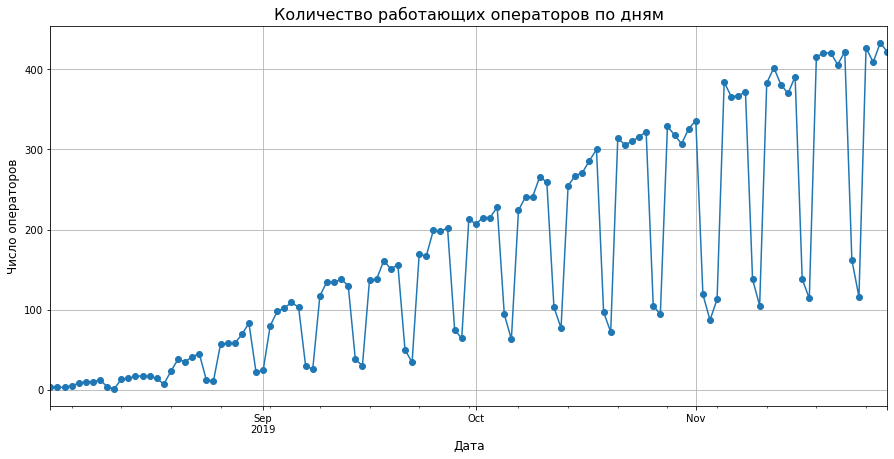

In [55]:
(df
 .pivot_table(index='date', values='operator_id', aggfunc='nunique')
 .plot(figsize=(15,7), style ='-o', grid=True, legend=False)
)
plt.title('Количество работающих операторов по дням', fontsize=16)
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Число операторов', fontsize = 12);

Число активных операторов непрерывно растет на протяжении всего исследуемого периода, что скорее всего говорит о том, что с каждым днем мы получали все больше полноценных данных

Операторы не звонят сами по себе, они работают колл-центрах, чтобы лучше понимать операторские статистики, проведем анализ колл-центров

#### Исследовательский анализ колл-центров

In [56]:
df.user_id.nunique()

307

В датасете 307 колл-центров, для анализа сгруппируем данные по каждому колл-центру

In [57]:
user_df = (df.groupby('user_id')
                 .agg({'date':'nunique', 'operator_id':'nunique','c_in':'sum','cm_in':'sum','c_out':'sum','cm_out':'sum','c_in_cd':'sum','c_in_tcd':'sum','cm_in_tcd':'sum','c_out_cd':'sum','c_out_tcd':'sum','cm_out_tcd':'sum'})
                 .reset_index()
                 .rename(columns={'date': 'work_days', 'operator_id':'op_count'})
)
user_df.sort_values(by=['op_count'], ascending=False).head()

,user_id,work_days,op_count,c_in,cm_in,c_out,cm_out,c_in_cd,c_in_tcd,cm_in_tcd,c_out_cd,c_out_tcd,cm_out_tcd
264,168187,44,51,5497.00,2457.00,6393.00,7051.00,598957.00,653483.00,71167.00,541651.00,672866.00,178203.00
175,167626,27,49,3720.00,23395.00,34703.00,31588.00,222653.00,248936.00,30450.00,2943741.00,3570326.00,802293.00
161,167497,63,31,328.00,313.00,2046.00,897.00,40694.00,48136.00,8075.00,235608.00,264045.00,21637.00
271,168252,41,29,8487.00,5581.00,7459.00,4977.00,987167.00,1024695.00,123283.00,607119.00,733413.00,114049.00
248,168062,25,28,411.00,249.00,9985.00,14712.00,39806.00,48522.00,2829.00,570215.00,703162.00,316053.00


In [58]:
# вычисляем различные параметры для будущей оценки эффективности операторов, подробное описание будет ниже
user_df['calls_in_pd'] = (user_df.c_in+user_df.cm_in)/(user_df.work_days)
user_df['miss_in_pct'] = (user_df.cm_in)/(user_df.c_in+user_df.cm_in)*100
user_df['calls_made_pd'] = (user_df.c_out)/(user_df.work_days)
user_df['calls_miss_pd'] = (user_df.cm_out)/(user_df.work_days)
user_df['rc_wait_time'] = (user_df.c_in_tcd-user_df.c_in_cd)/(user_df.c_in)
user_df['avr_call_in'] = (user_df.c_in_tcd+user_df.cm_in_tcd)/(user_df.c_in+user_df.cm_in)
user_df['mc_wait_time'] = (user_df.cm_in_tcd)/(user_df.cm_in)
user_df['avr_call_out'] = (user_df.c_out_tcd+user_df.cm_out_tcd)/(user_df.c_out+user_df.cm_out)

In [59]:
# убираем ненужные столбцы
user_df.drop(['c_in','cm_in','c_out','cm_out','c_in_cd','c_in_tcd','cm_in_tcd','c_out_cd','c_out_tcd','cm_out_tcd'], axis=1, inplace=True)

In [60]:
user_df.sort_values(by='work_days', ascending=False).head(10)

,user_id,work_days,op_count,calls_in_pd,miss_in_pct,calls_made_pd,calls_miss_pd,rc_wait_time,avr_call_in,mc_wait_time,avr_call_out
4,166405,111,11,69.47,71.77,58.22,30.30,18.47,64.32,13.43,97.39
22,166582,105,4,71.15,65.02,768.36,536.68,8.69,34.89,13.70,84.47
30,166658,101,18,23.00,34.74,68.50,35.18,10.29,175.70,5.91,205.55
13,166503,99,7,4.93,44.88,5.40,4.12,35.26,74.15,46.47,75.14
51,166782,98,6,32.81,13.75,40.74,25.30,6.74,71.15,16.23,52.14
39,166691,96,3,5.85,16.90,7.94,2.64,6.79,74.68,21.23,58.22
5,166406,91,4,2.84,37.21,60.44,28.88,13.91,68.12,34.92,52.61
36,166678,90,7,7.07,25.00,8.03,5.33,8.97,111.45,11.25,66.18
80,166983,88,6,34.92,10.51,45.09,20.91,10.02,145.12,39.46,98.08
0,166377,87,6,2.25,47.96,36.40,20.53,6.39,48.62,15.33,76.46


- `operator_id` — идентификатор оператора
- `work_days` — число рабочих дней колл-центра
- `op_count` - число операторов работающих в колл-центре
- `calls_in_pd` — среднее число входящих звонков колл-центром за день
- `miss_in_pct` — процент пропущенных входящих звонков
- `calls_made_pd` — среднее число "дозвонов" колл-центра за день
- `calls_miss_pd` — среднее число "недозвонов" колл-центра за день
- `rc_wait_time` — среднее время ожидания (в секундах) у принятых звонков
- `avr_call_in` — общее среднее время (в секундах) входящих звонков 
- `mc_wait_time` — среднее время ожидания (в секундах) у пропущенных звонков
- `avr_call_out` — общее среднее время (в секундах) потраченое колл-центром на исходящий звонок

In [61]:
user_df.describe().loc[['mean','50%','75%','min','max']]

,user_id,work_days,op_count,calls_in_pd,miss_in_pct,calls_made_pd,calls_miss_pd,rc_wait_time,avr_call_in,mc_wait_time,avr_call_out
mean,167456.82,33.85,4.55,15.95,56.32,24.16,21.22,14.49,56.94,15.27,70.70
50%,167455.00,28.00,3.00,3.15,53.85,1.46,1.07,13.50,48.62,13.83,62.46
75%,167996.50,52.00,5.00,8.63,79.47,12.35,6.50,18.09,81.57,22.33,87.22
min,166377.00,1.00,1.00,0.03,0.00,0.00,0.00,0.80,0.00,0.00,0.00
max,168606.00,111.00,51.00,1004.26,100.00,1285.30,1169.93,41.95,303.62,77.00,698.00


Работают колл-центры больше, чем отдельные операторы, что логично - 28 медианных рабочих дней в 2.5 раза больше чем у операторов;  
75% колл-центров имеют всего от 1 до 5-ти операторов, не очень много, самый многочисленный - 51 оператор;  
Среднее время исходящего звонка на 20% больше среднего времени входящего звонка;  
Процент пропущенных звонков сильно отличается от процента пропущенных звонков операторами, посмотрим на это подробнее

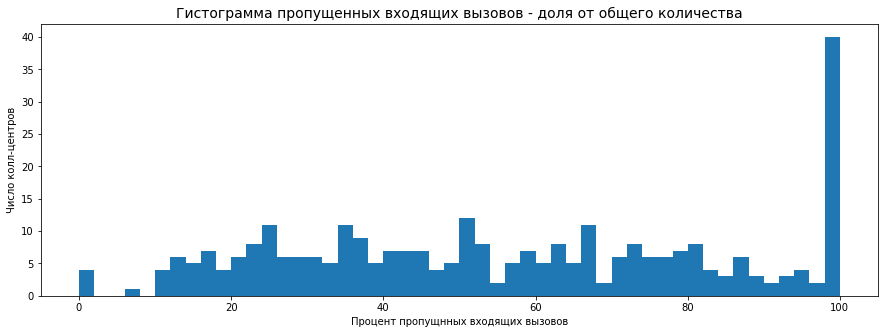

In [62]:
plt.figure(figsize=(15, 5))
plt.hist(user_df.miss_in_pct, density=False, bins=50)
plt.title("Гистограмма пропущенных входящих вызовов - доля от общего количества", fontsize = 14)
plt.ylabel('Число колл-центров')
plt.xlabel('Процент пропущнных входящих вызовов');

В наших данных было 15% записей с пропущенным идентификаторм оператора, удалять мы их не стали, и по ним стало видно, проблемы пропущенных звонков в разрезе операторов нет, а вот в разрезе колл-центров она существенна - средний процент пропущенных звонков - 56%;
Только 4 КЦ среди тех кому звонили, не имеют пропущенных вызовов, а 100% пропущенных у 40 колл-цетров

Из данных виднно, часть КЦ работает только на обзвон, а часть на прием звонков, большинство и принимает звонки и обзванивает;
Для оценки эффективности операторов нам необходимо знать, какая работа его основная - прием или обзвон, для этого категоризируем колл-центры

#### Категоризация колл-центров

Если соотношение входящих и исходщих звонков больше чем 80%, то колл-центр "принимающий" или "обзванивающий", во всех остальных случаях присваиваем категорию "универсальный"

In [63]:
user_df.loc[(user_df.calls_in_pd/(user_df.calls_made_pd+user_df.calls_miss_pd))<1/4, 'category'] = "обзванивающий"
user_df.loc[(user_df.calls_in_pd/(user_df.calls_made_pd+user_df.calls_miss_pd))>4, 'category'] = "принимающий"
user_df.loc[user_df.category.isna()==True, 'category'] = "универсальный"

In [64]:
cat_df = (user_df.groupby('category')
                      .agg({'user_id':'count', 'op_count':'sum'})
                      .rename(columns={'user_id': 'call_center_num'})
              )
cat_df['op_cut'] = cat_df.op_count / user_df.op_count.sum()
cat_df['op_count'] = cat_df.call_center_num / df.user_id.nunique()
cat_df = cat_df.rename(columns={'op_count': 'cc_cut'})
cat_df.sort_values(by='call_center_num', ascending=False).style.format({'cc_cut': '{:.1%}','op_cut':'{:.1%}'})

,call_center_num,cc_cut,op_cut
category,,,
принимающий,125,40.7%,23.3%
универсальный,115,37.5%,45.1%
обзванивающий,67,21.8%,31.6%


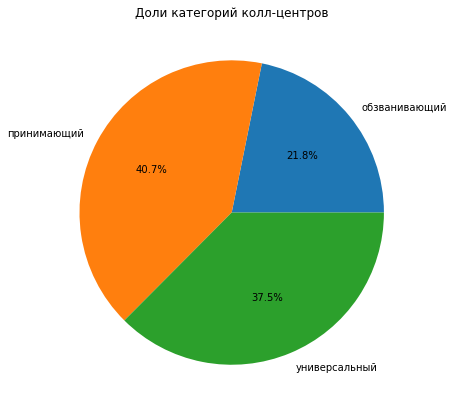

In [65]:
cat_df.plot(y='call_center_num', x='category', kind='pie', figsize=(7, 7), title='Доли категорий колл-центров', autopct='%1.1f%%', legend=False)
plt.ylabel('')
plt.show()

Обзванивающих КЦ меньше принимающих почти в 2 раза, универсальных чуть больше трети;  
Доля операторов в обзванивающих КЦ (31.6%) при этом больше, чем в принимающих (23.3%), неудивительна проблема с пропущенных звонков у принимающих колл-центров

#### Вывод

* Датасет содержит данные за 119 дней со 2-го августа 2019 по 28 ноября 2019 года;
* Судя по всему "полнота" данных увеличивается на всем периоде исследования, об этом говорят увеличивающееся количество звонков и число операторов;
* В выходные и праздничные дни большинство колл-центров не работает, что вполне логично;
* Число операторов 1092;
* У операторов КЦ в датасете очень мало рабочих дней - 75% опов работало 26 дней и меньше;
* В исследовании 307 КЦ;
* В 75% процентах из них работает 5-ть операторов и меньше, в самом большом полсотни;
* Средний процент пропущенных звонков у колл-центров 56%, только 4 КЦ не имеют пропущенных вызовов;
* Сделали категоризацию - если соотношение входящих и исходящих вызовов больше чем 80% на 20%, то КЦ "принимающий" или "обзванивающий" соответственно, все остальные КЦ - "универсальные";
* Большинство КЦ - принимающие (41%), обзванивающих только (22%), при этом доли операторов другие, больше всего у универсальных (45%), меньше всего у принимающих (23%);

### Определение эффективности операторов

#### Критерий эффективности оператора для 'обзванивающих' КЦ

Продолжительность рабочего дня 8 часов; на подготовку к звонку, формализацию результатов звонка(предполагаю, что по каждому звонку нужно делать некий отчет) и "перекур" будет потрачено 3/4-ти рабочего времени, отсюда 2 часа оператор "должен" звонить, если среднее значение total_call_duration за общее количество рабочих дней данного оператора меньше 7200 секунд, то оператор "мало звонит"

In [66]:
# создаем список из идентификаторов "обзванивающих КЦ" 
list_cc = list(user_df['user_id'])

In [67]:
# группируем по номеру оператора и суммируем все время что оператор "на телефоне"
df_effective_out = (df.query('user_id in @list_cc & operator_id != 333')
                       .groupby('operator_id')
                       .agg({'date':'nunique', 'c_in_tcd':'sum','cm_in_tcd':'sum','c_out_tcd':'sum','cm_out_tcd':'sum'})
                       .reset_index()
                       .rename(columns={'date': 'work_days'})
)
# находим среднее время за день, которое оператор тратит на звонки
df_effective_out['average_time_calling'] = (df_effective_out.c_in_tcd + df_effective_out.c_in_tcd + df_effective_out.c_out_tcd + df_effective_out.cm_out_tcd)/df_effective_out.work_days
# убираем ненужные столбцы
df_effective_out = df_effective_out.drop(['c_in_tcd','cm_in_tcd','c_out_tcd','cm_out_tcd'], axis=1)
# фильтруем по среднему времени меньшее 7200
list_none_effective_out = df_effective_out.query('average_time_calling<7200')
list_none_effective_out.sort_values(by='average_time_calling', ascending=False) #.style.format({'average_time_calling': '{:.0f}'})

,operator_id,work_days,average_time_calling
268,906070,18,7168.17
1033,961064,8,7089.25
501,921592,12,7066.50
784,940622,17,7064.53
505,921818,60,7029.62
...,...,...,...
982,955068,1,0.00
1011,958458,1,0.00
386,914626,1,0.00
1030,960674,1,0.00


In [68]:
print('Количество неэффективный операторов работающих в КЦ категории "обзванивающий":', list_none_effective_out.operator_id.nunique())
print('Общее количество операторов в КЦ категории "обзванивающий":', df_effective_out.operator_id.nunique())

Количество неэффективный операторов работающих в КЦ категории "обзванивающий": 1009
Общее количество операторов в КЦ категории "обзванивающий": 1092


97% операторов колл-центров из категории "обзванивающий" работают "на телефоне" меньше 2-х часов в день, даже учитывая входящие звонки и внутренние разговоры;  
Либо наши критерии категоризации не смогли выделить настоящие обзванивающие КЦ, либо их тут нет; не исключена ситуация что мы работаем с неполными данными

#### Критерий эффективности для операторов на входящих звонках - ожидание ответа

Вычисляем среднее время ожидание ответа у входящих пропущенных звонков - это и будет ориентир для порога эффективности

In [69]:
df_effective_answer = df.cm_in_tcd.sum()/df.cm_in.sum()
print('Среднее время ожидание ответа у пропущенных входящих звонков: {0:.1f} секунды'.format(df_effective_answer))

Среднее время ожидание ответа у пропущенных входящих звонков: 12.2 секунды


Время ответа для входящих звонков у эффективных операторов не больше 10 секунд

In [70]:
list_none_effective_answer10 = operator_df.query('mc_wait_time > 10')[['operator_id','mc_wait_time']]
list_none_effective_answer10

,operator_id,mc_wait_time
10,882680,31.00
11,882684,16.50
12,882686,15.75
14,882690,60.00
22,884408,14.00
...,...,...
822,944222,38.07
823,944226,49.54
838,945046,21.50
917,948758,41.00


In [71]:
print('Количество неэффективный операторов по времени ответа:', list_none_effective_answer10.operator_id.nunique())
print('Общее количество операторов в КЦ категории "обзванивающий":', df.operator_id.nunique()-1)
print('Доля неэффективных от общего числа {0:.1%}'.format(list_none_effective_answer10.operator_id.nunique()/(df.operator_id.nunique()-1)))

Количество неэффективный операторов по времени ответа: 115
Общее количество операторов в КЦ категории "обзванивающий": 1092
Доля неэффективных от общего числа 10.5%


Найдем в каких колл-центрах работают неэффективные операторы и посчитаем их долю от всех операторов работающих в этом КЦ

In [72]:
# создаем лист из id неэффективных операторов (критерий эффективности - ответ на звонок 10 сек или быстрее)
id_op_list = list(list_none_effective_answer10.operator_id)
# таблица с колл-центрами и числом неэффективных операторов в них
list_cc = df.query('operator_id in @id_op_list').groupby('user_id').agg({'operator_id':'nunique'}).reset_index()
# создаем лист из id колл-центров в которых работают неэффективные операторы
id_cc_list = list(list_cc.user_id)
# таблица с колл-центрами в которых работают неэффективные операторы и общее число операторов работающих в данном КЦ
list_cc_full = df.query('user_id in @id_cc_list').groupby('user_id').agg({'operator_id':'nunique'}).reset_index()
# соединяем 2 таблицы по номеру колл-центра и переименновываем столбцы
cc_stats = list_cc_full.merge(list_cc, on='user_id', how='left')
cc_stats = cc_stats.rename(columns={'operator_id_x':'total_operators', 'operator_id_y':'none_effective_num'})
# считаем долю неэффективных операторов в каждом КЦ
cc_stats['none_effective_cut'] = cc_stats.none_effective_num/cc_stats.total_operators

In [73]:
cc_stats.sort_values(by='none_effective_cut', ascending=False).head(7).style.format({'none_effective_cut': '{:.1%}'})

,user_id,total_operators,none_effective_num,none_effective_cut
63,167977,6,5,83.3%
32,167071,3,2,66.7%
31,167059,8,5,62.5%
55,167650,5,3,60.0%
43,167235,2,1,50.0%
11,166619,2,1,50.0%
36,167158,2,1,50.0%


In [74]:
cc_stats.sort_values(by='none_effective_num', ascending=False).head(7).style.format({'none_effective_cut': '{:.1%}'})

,user_id,total_operators,none_effective_num,none_effective_cut
71,168187,51,10,19.6%
0,166405,11,5,45.5%
31,167059,8,5,62.5%
63,167977,6,5,83.3%
23,166916,17,4,23.5%
47,167445,12,3,25.0%
55,167650,5,3,60.0%


Мы можем предложить наши услуги по оценке эффективности КЦ - 167977, 167071, 167059, 167650 - у этих колл-центров доля неэффективных операторов больше 50%;  
Также наш фильтр может заинтересовать КЦ - 168187, 166405, 166916 - у них число неэффективных операторов больше 3-х

Проверим пороги эффективности в 11, 12 и 5 секунд

In [75]:
list_none_effective_answer11 = operator_df.query('mc_wait_time > 11')[['operator_id','mc_wait_time']]
print('Количество неэффективный операторов по времени ответа:', list_none_effective_answer11.operator_id.nunique())
print('Доля неэффективных от общего числа {0:.1%}'.format(list_none_effective_answer11.operator_id.nunique()/(df.operator_id.nunique()-1)))

Количество неэффективный операторов по времени ответа: 105
Доля неэффективных от общего числа 9.6%


In [76]:
list_none_effective_answer12 = operator_df.query('mc_wait_time > 12')[['operator_id','mc_wait_time']]
print('Количество неэффективный операторов по времени ответа:', list_none_effective_answer12.operator_id.nunique())
print('Доля неэффективных от общего числа {0:.1%}'.format(list_none_effective_answer12.operator_id.nunique()/(df.operator_id.nunique()-1)))

Количество неэффективный операторов по времени ответа: 98
Доля неэффективных от общего числа 9.0%


In [77]:
list_none_effective_answer5 = operator_df.query('mc_wait_time > 5')[['operator_id','mc_wait_time']]
print('Количество неэффективный операторов по времени ответа:', list_none_effective_answer5.operator_id.nunique())
print('Доля неэффективных от общего числа {0:.1%}'.format(list_none_effective_answer5.operator_id.nunique()/(df.operator_id.nunique()-1)))

Количество неэффективный операторов по времени ответа: 146
Доля неэффективных от общего числа 13.4%


Даже при пороге в 10 секунд доля неэффективных операторов по времени ответа не велика - 10.5%, при поднятие порога до 12 секунд - доля неэффективных падает до 9%, при "жестком" пороге в 5 секунд - доля неэффективных увеличивается не значительно до 13.4%

#### Критерий эффективности для операторов на входящих звонках - доля пропущенных

Колл-центру необходимо уменьшить долю пропусков входящих звонков до числа n (в процентах), и сделать это необходимо за счет тех операторов, что уже есть, они должны повысить эффективность - уменьшить долю пропущенных звонков

In [78]:
# задаем требуемый % пропущенных
n=5

# собираем таблицу по номеру КЦ, cm_333 - число пропущенных вызовов, которым не был назначен оператор
user_eff = (df.groupby('user_id')
                 .agg({'c_in':'sum','cm_in':'sum', 'cm_333':'sum'})
                 .reset_index()
           )
# вычисляем число пропущенных звонков операторами - только это число мы можем уменьшить
user_eff['cm_none_333'] = user_eff.cm_in - user_eff.cm_333

# вычисляем какое число принятых звонков должно быть, чтобы удовлетворяло нашему порогу,
# при том что число пропущенных звонков без назначенного оператора остается неизменным
user_eff['c_in_must_be'] = user_eff.cm_333*(100/n)

# вычисляем максимально возможное число принятых вызовов - все операторы 0% пропущенных
user_eff['c_in_possible'] = user_eff.c_in + user_eff.cm_none_333

# считаем коэффициент на который операторы должны будут уменьшить число пропущеных вызовов
user_eff['koef'] = (user_eff.c_in_possible - user_eff.c_in_must_be)/user_eff.c_in_must_be

# присваиваем коэффициенту 0, если нет непринятых звонков у неназначенных операторов 
# или число звонков которое возможно сделать принятыми меньше необходимого - у нас не хватает "запаса неэффективности"
user_eff.loc[(user_eff.cm_none_333==0) | (user_eff.c_in_possible < user_eff.c_in_must_be), 'koef'] = 0

# присваиваем 1 если текущее число пропущенных вызовов больше или равно нужному нам пределу - улучшать ничего не надо
user_eff.loc[(user_eff.c_in >= user_eff.c_in_must_be, 'koef')] = 1

user_eff .query('koef >0')

,user_id,c_in,cm_in,cm_333,cm_none_333,c_in_must_be,c_in_possible,koef
186,167682,2.00,0.00,0.00,0.00,0.00,2.00,1.00
272,168253,3536.00,39.00,31.00,8.00,620.00,3544.00,1.00
280,168315,409.00,7.00,7.00,0.00,140.00,409.00,1.00
290,168459,5.00,0.00,0.00,0.00,0.00,5.00,1.00


В нашем датасете нет колл-центров, которые способны улучшить статистику до требуемого уровня (5% - пропущенных), даже если все операторы будут принимать звонки со 100% эффективностью;  
Зато есть 4 колл-центра с долей пропущенных меньше 5%

#### Вывод

* 'Время ответа оператора при входящем звонке' - единственный из критериев, который можно использовать как фильтр эффективности;
  - Мы можем предложить наши услуги по оценке эффективности КЦ - 167977, 167071, 167059, 167650 - у этих колл-центров доля неэффективных операторов больше 50%;  
  - Также наш фильтр может заинтересовать КЦ - 168187, 166405, 166916 - у них число неэффективных операторов больше 3-х
* 'Критерий обзвона' - не прошел почти никто, а 'долю пропущенных входящих' - наоборот, прошли все;
* Проблема не фильтрах а в полноте данных - у 75% операторов 26 или меньше дней статистики и как следствие мало данных для более качественного анализа;
* Часть данных просто ошибочна или неправильно собрана - есть операторы у которых рабочее время за сутки больше чем 24 часа; 
* Данные мы получаем в агрегированом виде из-за чего вынуждены пользоваться средними значениями и общими суммами;

### Проверка гипотез

#### Число исходящих звонков  за день отличается от  числа входящих звонков за день

H0 - количество звонков в день у операторов на исходящих и входящих вызовах равно  
H1 - количество звонков в день у операторов на исходящих и входящих вызовах различается

In [79]:
# группируем входящие и исходящие звонки по дате
tt_test = (df.groupby('date')
             .agg({'c_in':'sum','cm_in':'sum','c_out':'sum','cm_out':'sum'})
             .reset_index()
)
# создаем столбец с числом входящих звонков за каждую дату
tt_test['calls_in'] = tt_test.c_in + tt_test.cm_in
# создаем столбец с числом исходящих звонков за каждую дату
tt_test['calls_out'] = tt_test.c_out + tt_test.cm_out
# создаем столбец с процентом успешных звонков за день (для проверки 2-ой гипотезы)
tt_test['pct_success_calls'] = (tt_test.c_in + tt_test.c_out)/(tt_test.c_in + tt_test.cm_in + tt_test.c_out + tt_test.cm_out)
# создаем столбец с днем недели (для проверки 2-ой гипотезы)
tt_test['weekday'] = tt_test.date.dt.day_name()

# подсчитываем общее число звонков и число состоявшихся звонков в будние дни (для проверки 2-ой гипотезы)
workday = tt_test.query('weekday in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]')
workday_all = workday.c_in.sum() + workday.cm_in.sum() + workday.c_out.sum() + workday.cm_out.sum()
workday_success = workday.c_in.sum() + workday.c_out.sum()
# подсчитываем общее число звонков и число состоявшихся звонков в будние дни (для проверки 2-ой гипотезы)
weekend = tt_test.query('weekday in ["Saturday", "Sunday"]')
weekend_all = weekend.c_in.sum() + weekend.cm_in.sum() + weekend.c_out.sum() + weekend.cm_out.sum()
weekend_success = weekend.c_in.sum() + weekend.c_out.sum()

# удаляем не нужные столбцы
tt_test = tt_test.drop(['c_in','cm_in','c_out','cm_out'], axis=1)
tt_test.head(7).style.format({'date': '{:%m-%d}','calls_in': '{:.0f}', 'calls_out': '{:.0f}','pct_success_calls':'{:.1%}'})

,date,calls_in,calls_out,pct_success_calls,weekday
0,08-02,2,19,28.6%,Friday
1,08-03,3,26,65.5%,Saturday
2,08-04,2,4,16.7%,Sunday
3,08-05,12,180,70.8%,Monday
4,08-06,52,177,59.0%,Tuesday
5,08-07,12,169,80.1%,Wednesday
6,08-08,13,341,68.6%,Thursday


In [80]:
# создаем две выборки с входящими и исходящими звонками
in_test = tt_test.calls_in
out_test = tt_test.calls_out
# пороговое значение
alpha = .05
# для проверки гипотезы используем метод ttest_ind
results = st.ttest_ind(in_test, out_test, equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8065170003791554e-16
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, количество звонков в день у операторов на исходящих и входящих звонках различаются, а значит приоритет оценки эффетивности должны получить те операторы колл-цетров, звонков которых больше, в нашем случае операторы колл-центров 'обзванивающие'

#### Процент пропущенных вызовов в будние дни отличается от процента пропущенных вызовов в выходные

`H0 - процент пропущенных вызовов в будни равен проценту пропущенных вызовов в выходные`    
`H1 - процент пропущенных вызовов в будни отличается от процента пропущенных вызовов в выходные`  

Для проверки гипотез о равенстве долей (отсутствие статистически значимой разницы) используем z-test

In [81]:
n1 = workday_all
n2 = weekend_all

p1 = workday_success / n1
p2 = weekend_success / n2

p = (workday_success + weekend_success) / (n1 + n2)

z_value = (p1-p2)/mth.sqrt(p * (1-p) * (1/n1 + 1/n2))
        
distr = st.norm(0, 1) 
p_value = (1 - distr.cdf(abs(z_value))) * 2
alpha = .05

print('p-значение:', results.pvalue)

if (p_value < alpha):
    print("Нулевая гипотеза отвергнута: разница между долями статистически значима\n")
else:
    print("Нулевая гипотеза не отвергнута: между долями в группах нет статистически значимой разницы\n")

p-значение: 2.8065170003791554e-16
Нулевая гипотеза отвергнута: разница между долями статистически значима



Поскольку доли пропущенных вызовов в будни и выходные отличаются, то имеет смысл различать или скорректировать оценки эффективности операторов основанные на проценте состоявшихся звонков в будние и выходные дни

#### Вывод

* Для количественных данных применили Т-критерий Стьюдента для проверки гипотез:   
  Гипотеза: "Количество звонков в день у операторов на исходящих и входящих вызовах равно" - отвергнута;  

* Для проверки гипотез о равенстве долей использовали z-test  
  Гипотеза: "Процент пропущенных вызовов в будни равен проценту пропущенных вызовов в выходные" - отвергнута

### Общий вывод

* При предобработке данных выявлены и удалены 4900 дублей, в столбцах internal и operator_id обнаружены пропуски они были заменены, исправили часть данных в столбце is_missed_call, изменили тип данных у столбцов date и operator_id;  
* Датасет содержит данные за 119 дней со 2-го августа 2019 по 28 ноября 2019 года;
* Данные на всем периоде исследования распределены неравномерно - в начале данных очень мало затем количество данных непрерывно растет;
* Количество операторов 1092, по 75% из них статистика есть только за 26 дней или меньше;
* Число колл-центров 307, средний процент пропущенных входящих звонков - 56%;
* В 75% колл-центров работает 5 и меньше операторов;
* Осуществили категоризацию колл-центров на 'принимающие' (41%), 'обзванивающие' (22%) и 'универсальные' (37%), больше всего операторов задействовали 'обзванивающие' колл-центры (32%), а меньше всего 'принимающие' (23%);
* Вывели и применили 3 критерия эффективности операторов:
  - 'Время ответа оператора при входящем звонке' - 10% операторов, к которым он был применен, не прошли этот фильтр;
  - 'Мало звонит' - 97% операторов из колл-цетров категории 'обзванивающий', звонят меньше 2-х часов в день;
  - '% пропущенных входящих' - 100% операторов прошли фильтр;
* Проверили две статистические гипотезы:
  - 'Количество звонков в день у операторов на исходящих и входящих вызовах равно' - отвергнута
  - 'Процент пропущенных вызовов в будни равен проценту пропущенных вызовов в выходные' - отвергнута 

#### Рекомендации

* На тех данных, что есть сейчас, построить качественные фильтры оценки операторов крайне сложно, если вообще возможно;
* Если наши данные корректны - 5-ть и меньше операторов в 75% колл-центрах и 28 рабочих из 119-ти дней у половины КЦ, то тратить ресурсы на разработку дополнительных фич крайне сомнительная затея, фичу просто не купят, потому что "не кому и не зачем";
* Для разработки какого-то эффективного и неочевидного фильтра, нужно получить больше данных и в смысле количества, и в смысле их полноты